In [1]:
import os
import sys
import math
import json
import time
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import the Modules dir
project_path = "<PATH-TO-REPO>/BiMAEB-UDD-RUL/"
sys.path.insert(0, project_path)

from Modules.Models import AutoEncoder
from experimental_results.functions import (TURBOFAN_FEATURES_LIST, 
                       save_labeled_dataframe,
                       normalize_df, 
                       normalize_df_with_context,
                       get_model_reconstructions, 
                       get_latent_space_df)

from experimental_results.unsupervised_labeling_functions import (label_df, 
                                                                  plot_latent_space,
                                                                  plot_labels_recon_errors_and_threshold, 
                                                                  create_unsupervised_labeled_dataset)

# Define the number of samples that were defined as normal in the time-series

In [2]:
normal_op_len = 45
norm_op_len_as_pct = True

dataset = "FD002"
model_type = "AE"
prefix = "Pct" if norm_op_len_as_pct else "Len"


print(f"Normality: {normal_op_len} {prefix}")

Normality: 45 Pct


# Define Paths and File Names

In [3]:
model_name = f"normOp{prefix}{normal_op_len}_{model_type}"

# Define path's to data directories.
path_to_training_data_dir = "<PATH-TO-DATA-DIR>//NASA_turbofan_data/train"
path_to_testing_data_dir = "<PATH-TO-DATA-DIR>/NASA_turbofan_data/validation"

# Define CSV file names
csv_file_training = f"{dataset}_train.csv"
csv_file_testing = f"{dataset}_test.csv"

# Define paths
dataset_path_training = os.path.join(path_to_training_data_dir, csv_file_training)
dataset_path_testing = os.path.join(path_to_testing_data_dir, csv_file_testing)

path_to_model_state_dict = f"models/{model_name}_model_state_dict"

print(f"Model Path: {path_to_model_state_dict}")

Model Path: models/normOpPct45_AE_model_state_dict


# Load the Training and Testing Data. Normalize them too

In [4]:
print(f"Reading dataset \n{dataset_path_training}\n")
print(f"Reading dataset \n{dataset_path_testing}")

# Read data
df_training_not_normalized = pd.read_csv(dataset_path_training)
df_testing_not_normalized = pd.read_csv(dataset_path_testing)

print("\nNormalizing datasets...\n")
# Normalize Datasets
df_training_normalized = normalize_df(df=df_training_not_normalized, 
                                      model_features=TURBOFAN_FEATURES_LIST)

df_testing_normalized = normalize_df_with_context(df=df_testing_not_normalized, 
                                                  df_context=df_training_not_normalized, 
                                                  model_features=TURBOFAN_FEATURES_LIST)
print("Done!")

Reading dataset 
/Users/rafaeltoche/Documents/School/Research/Rainwaters_Lab/DART-LP2/Condition_Monitoring/data/NASA_turbofan_data/train/FD002_train.csv

Reading dataset 
/Users/rafaeltoche/Documents/School/Research/Rainwaters_Lab/DART-LP2/Condition_Monitoring/data/NASA_turbofan_data/validation/FD002_test.csv

Normalizing datasets...

Done!


In [5]:
# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using Device: {}".format(device))

Using Device: cpu


# Set Model and Data Parameters. 
`window_size` is a variable that tells us how many samples in each sample. 
`latent_size` is a variable that defines the latent space size.

In [6]:
window_size = 1
latent_size = 16
ts_number_features = len(TURBOFAN_FEATURES_LIST)

print(f"Latent Size: {latent_size}")
print(f"Number ts features: {ts_number_features}")

Latent Size: 16
Number ts features: 24


# Load the Trained Model

In [7]:
model = AutoEncoder(ts_number_features=ts_number_features,
                    latent_size=latent_size,
                    device=device,
                    model_name="",
                    metrics_dir="model")

print(f"Reading model at '{path_to_model_state_dict}'")
model.load_state_dict(torch.load(path_to_model_state_dict, map_location=torch.device(device)))

Reading model at 'models/normOpPct45_AE_model_state_dict'


<All keys matched successfully>

# Label Both Training and Testing Data With the Model

In [8]:
# Label Training Data!
num_contiguous_anomalous_samples = 3
num_stds = 3
df_unsuperivsed_labels_training, unit_thresholds_dict = create_unsupervised_labeled_dataset(
                                                            model=model, 
                                                            df=df_training_normalized, 
                                                            identifier_col="unit", 
                                                            cycle_col="cycle", 
                                                            fault_col="fault",
                                                            features_list=TURBOFAN_FEATURES_LIST,
                                                            normal_op_len=normal_op_len, 
                                                            normal_op_len_as_pct=norm_op_len_as_pct,
                                                            num_contiguous_anomalous_samples=num_contiguous_anomalous_samples,
                                                            num_stds=num_stds)

Unit 1
	Training Samples:    68
	Normal Samples:      67
	Abnormal Samples:    14

Unit 2
	Training Samples:    122
	Normal Samples:      77
	Abnormal Samples:    70

Unit 3
	Training Samples:    93
	Normal Samples:      96
	Abnormal Samples:    17

Unit 4
	Training Samples:    106
	Normal Samples:      65
	Abnormal Samples:    64

Unit 5
	Training Samples:    70
	Normal Samples:      52
	Abnormal Samples:    32

Unit 6
	Training Samples:    79
	Normal Samples:      80
	Abnormal Samples:    16

Unit 7
	Training Samples:    79
	Normal Samples:      61
	Abnormal Samples:    34

Unit 8
	Training Samples:    68
	Normal Samples:      61
	Abnormal Samples:    22

Unit 9
	Training Samples:    90
	Normal Samples:      91
	Abnormal Samples:    18

Unit 10
	Training Samples:    83
	Normal Samples:      83
	Abnormal Samples:    18

Unit 11
	Training Samples:    122
	Normal Samples:      84
	Abnormal Samples:    65

Unit 12
	Training Samples:    113
	Normal Samples:      119
	Abnormal Samples:    

Unit 111
	Training Samples:    90
	Normal Samples:      91
	Abnormal Samples:    19

Unit 112
	Training Samples:    171
	Normal Samples:      122
	Abnormal Samples:    85

Unit 113
	Training Samples:    105
	Normal Samples:      102
	Abnormal Samples:    25

Unit 114
	Training Samples:    92
	Normal Samples:      47
	Abnormal Samples:    64

Unit 115
	Training Samples:    93
	Normal Samples:      82
	Abnormal Samples:    31

Unit 116
	Training Samples:    94
	Normal Samples:      94
	Abnormal Samples:    19

Unit 117
	Training Samples:    80
	Normal Samples:      87
	Abnormal Samples:    10

Unit 118
	Training Samples:    155
	Normal Samples:      110
	Abnormal Samples:    79

Unit 119
	Training Samples:    79
	Normal Samples:      70
	Abnormal Samples:    25

Unit 120
	Training Samples:    59
	Normal Samples:      49
	Abnormal Samples:    21

Unit 121
	Training Samples:    95
	Normal Samples:      100
	Abnormal Samples:    15

Unit 122
	Training Samples:    84
	Normal Samples:      93

Unit 207
	Training Samples:    83
	Normal Samples:      74
	Abnormal Samples:    27

Unit 208
	Training Samples:    68
	Normal Samples:      73
	Abnormal Samples:    9

Unit 209
	Training Samples:    91
	Normal Samples:      91
	Abnormal Samples:    19

Unit 210
	Training Samples:    83
	Normal Samples:      80
	Abnormal Samples:    21

Unit 211
	Training Samples:    97
	Normal Samples:      47
	Abnormal Samples:    70

Unit 212
	Training Samples:    68
	Normal Samples:      69
	Abnormal Samples:    12

Unit 213
	Training Samples:    89
	Normal Samples:      43
	Abnormal Samples:    64

Unit 214
	Training Samples:    66
	Normal Samples:      63
	Abnormal Samples:    17

Unit 215
	Training Samples:    102
	Normal Samples:      58
	Abnormal Samples:    66

Unit 216
	Training Samples:    104
	Normal Samples:      105
	Abnormal Samples:    20

Unit 217
	Training Samples:    73
	Normal Samples:      81
	Abnormal Samples:    8

Unit 218
	Training Samples:    107
	Normal Samples:      78
	Abn

In [9]:
len(df_unsuperivsed_labels_training.query("fault==1")["unit"].unique())

260

In [10]:
df_unsupervised_labels_testing = create_unsupervised_labeled_dataset(
                                    model=model, 
                                    df=df_testing_normalized, 
                                    identifier_col="unit", 
                                    cycle_col="cycle", 
                                    fault_col="fault",
                                    features_list=TURBOFAN_FEATURES_LIST,
                                    normal_op_len=0, 
                                    normal_op_len_as_pct=norm_op_len_as_pct,
                                    num_contiguous_anomalous_samples=num_contiguous_anomalous_samples,
                                    num_stds=num_stds, 
                                    unit_thresholds_dict=unit_thresholds_dict)

Unit 1
	Training Samples:    0
	Normal Samples:      221
	Abnormal Samples:    37

Unit 2
	Training Samples:    0
	Normal Samples:      55
	Abnormal Samples:    0

Unit 3
	Training Samples:    0
	Normal Samples:      165
	Abnormal Samples:    0

Unit 4
	Training Samples:    0
	Normal Samples:      86
	Abnormal Samples:    0

Unit 5
	Training Samples:    0
	Normal Samples:      117
	Abnormal Samples:    31

Unit 6
	Training Samples:    0
	Normal Samples:      63
	Abnormal Samples:    0

Unit 7
	Training Samples:    0
	Normal Samples:      174
	Abnormal Samples:    10

Unit 8
	Training Samples:    0
	Normal Samples:      173
	Abnormal Samples:    0

Unit 9
	Training Samples:    0
	Normal Samples:      140
	Abnormal Samples:    21

Unit 10
	Training Samples:    0
	Normal Samples:      84
	Abnormal Samples:    0

Unit 11
	Training Samples:    0
	Normal Samples:      162
	Abnormal Samples:    0

Unit 12
	Training Samples:    0
	Normal Samples:      74
	Abnormal Samples:    0

Unit 13
	Train

Unit 116
	Training Samples:    0
	Normal Samples:      140
	Abnormal Samples:    31

Unit 117
	Training Samples:    0
	Normal Samples:      55
	Abnormal Samples:    0

Unit 118
	Training Samples:    0
	Normal Samples:      97
	Abnormal Samples:    0

Unit 119
	Training Samples:    0
	Normal Samples:      202
	Abnormal Samples:    0

Unit 120
	Training Samples:    0
	Normal Samples:      160
	Abnormal Samples:    0

Unit 121
	Training Samples:    0
	Normal Samples:      59
	Abnormal Samples:    0

Unit 122
	Training Samples:    0
	Normal Samples:      29
	Abnormal Samples:    0

Unit 123
	Training Samples:    0
	Normal Samples:      61
	Abnormal Samples:    0

Unit 124
	Training Samples:    0
	Normal Samples:      141
	Abnormal Samples:    8

Unit 125
	Training Samples:    0
	Normal Samples:      79
	Abnormal Samples:    0

Unit 126
	Training Samples:    0
	Normal Samples:      99
	Abnormal Samples:    0

Unit 127
	Training Samples:    0
	Normal Samples:      126
	Abnormal Samples:    0

Unit 217
	Training Samples:    0
	Normal Samples:      49
	Abnormal Samples:    0

Unit 218
	Training Samples:    0
	Normal Samples:      33
	Abnormal Samples:    0

Unit 219
	Training Samples:    0
	Normal Samples:      161
	Abnormal Samples:    0

Unit 220
	Training Samples:    0
	Normal Samples:      54
	Abnormal Samples:    0

Unit 221
	Training Samples:    0
	Normal Samples:      55
	Abnormal Samples:    0

Unit 222
	Training Samples:    0
	Normal Samples:      180
	Abnormal Samples:    0

Unit 223
	Training Samples:    0
	Normal Samples:      29
	Abnormal Samples:    0

Unit 224
	Training Samples:    0
	Normal Samples:      43
	Abnormal Samples:    0

Unit 225
	Training Samples:    0
	Normal Samples:      166
	Abnormal Samples:    0

Unit 226
	Training Samples:    0
	Normal Samples:      165
	Abnormal Samples:    0

Unit 227
	Training Samples:    0
	Normal Samples:      170
	Abnormal Samples:    10

Unit 228
	Training Samples:    0
	Normal Samples:      44
	Abnormal Samples:    0

# Save Data to Their Respective Directories

In [13]:
# Create the path where to save the DataFrame
file_name_for_labeled_training_data = csv_file_training[:-4] + f"_unsupervised_labels_{model.model_type}_Op{prefix}{normal_op_len}.csv"
save_labeled_dataframe(file_name=file_name_for_labeled_training_data, 
                       save_path=path_to_training_data_dir,
                       df_labeled=df_unsuperivsed_labels_training, 
                       df_unlabeled=df_training_not_normalized)

Saved 'FD002_train_unsupervised_labels_AutoEncoder_OpPct45.csv' to -->
'/Users/rafaeltoche/Documents/School/Research/Rainwaters_Lab/DART-LP2/Condition_Monitoring/data/NASA_turbofan_data/train'


In [14]:
file_name_for_labeled_testing_data = csv_file_testing[:-4] + f"_unsupervised_labels_{model.model_type}_Op{prefix}{normal_op_len}.csv"
save_labeled_dataframe(file_name=file_name_for_labeled_testing_data, 
                       save_path=path_to_testing_data_dir,
                       df_labeled=df_unsupervised_labels_testing, 
                       df_unlabeled=df_testing_not_normalized)

Saved 'FD002_test_unsupervised_labels_AutoEncoder_OpPct45.csv' to -->
'/Users/rafaeltoche/Documents/School/Research/Rainwaters_Lab/DART-LP2/Condition_Monitoring/data/NASA_turbofan_data/validation'


# Visualize one of the training samples

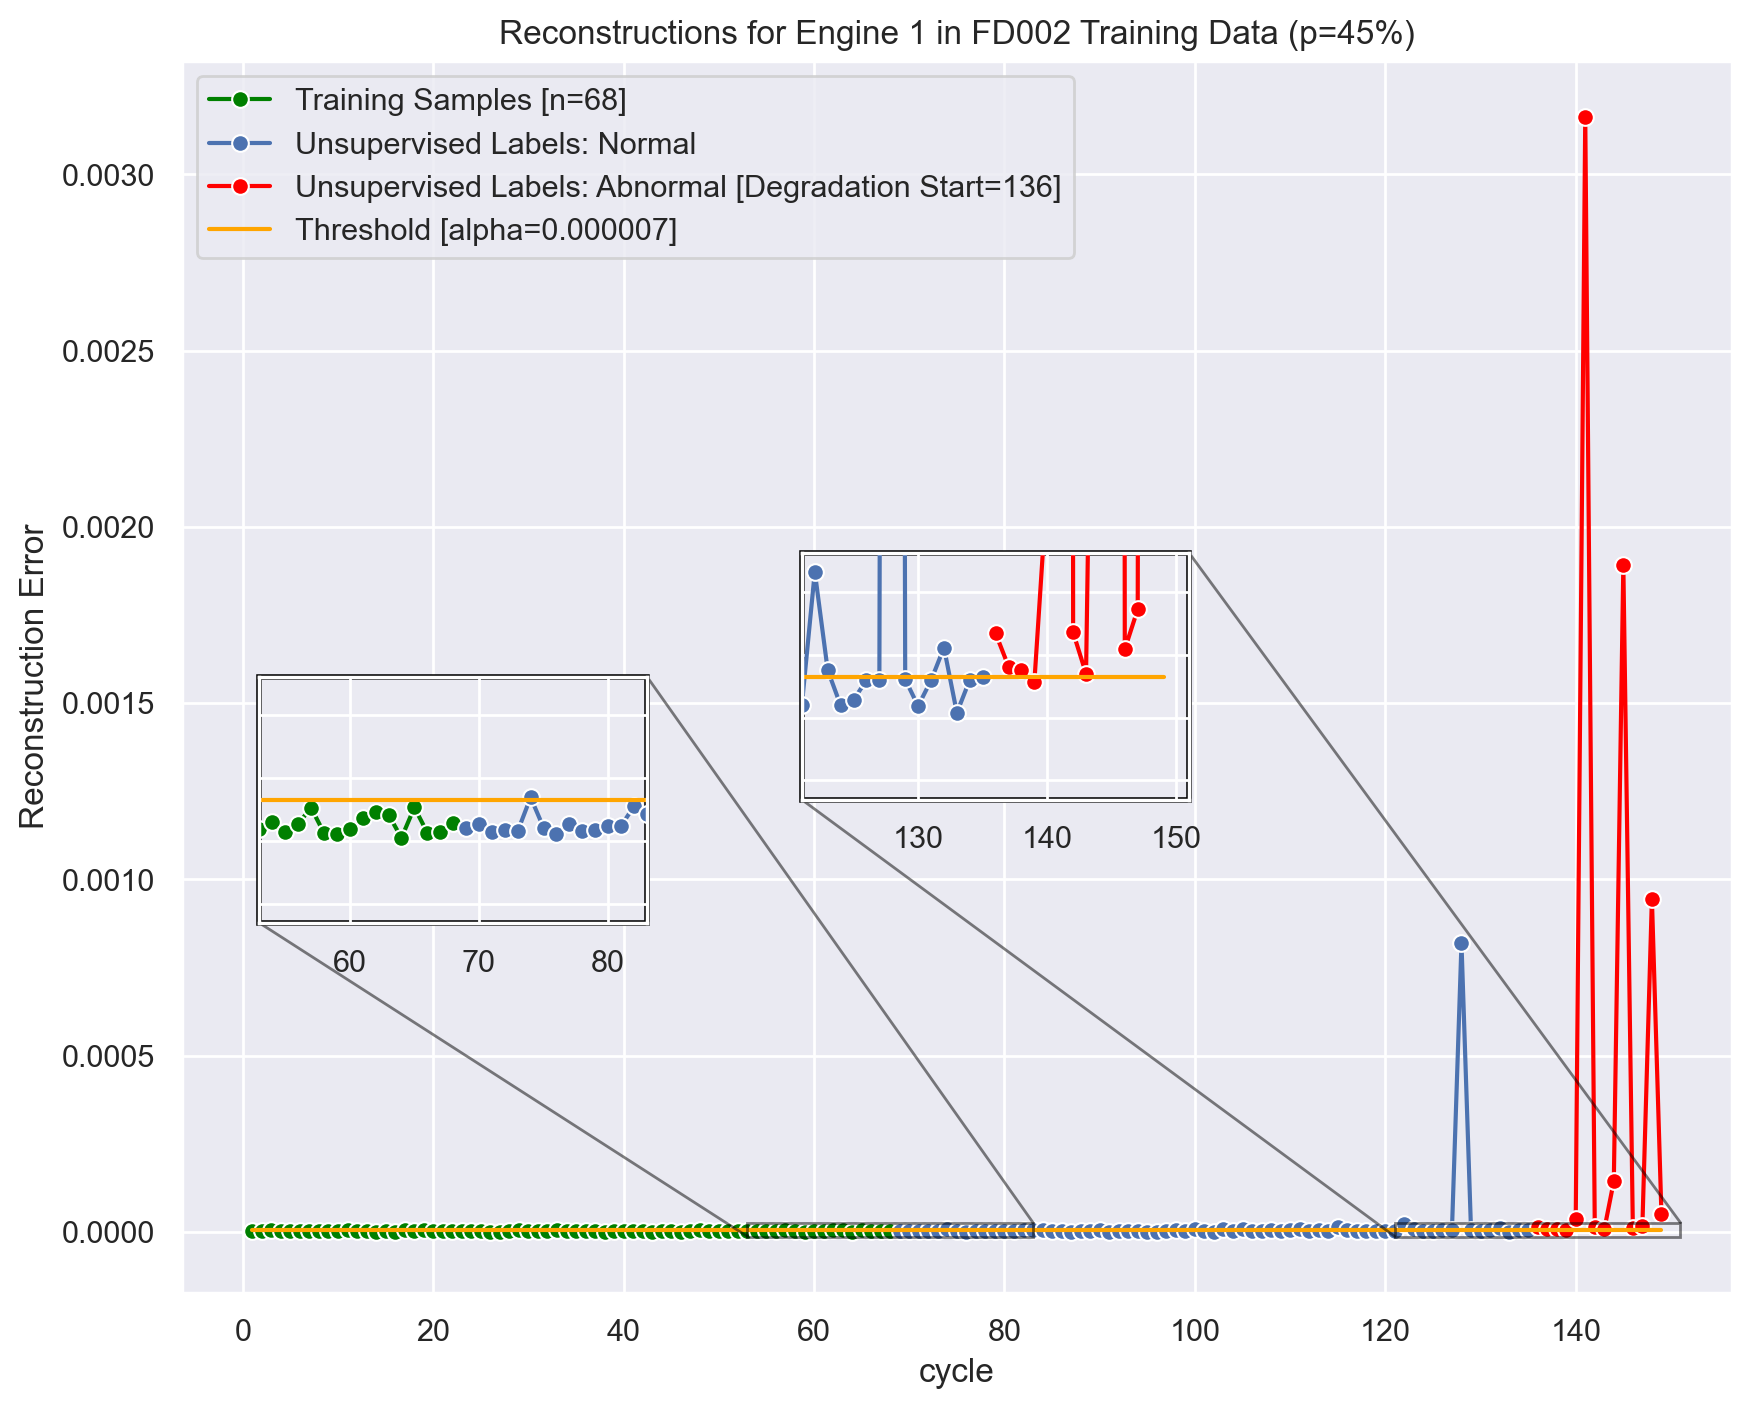

In [15]:
unit = 1
title = f"Reconstructions for Engine {unit} in {dataset} Training Data (p={normal_op_len}%)"
unit_threshold = unit_thresholds_dict[str(unit)]
df_unit = df_unsuperivsed_labels_training.query(f"unit=={unit}")
number_normal_samples = math.ceil((normal_op_len / 100) * len(df_unit)) if norm_op_len_as_pct else normal_op_len

plot_labels_recon_errors_and_threshold(model, 
                                       number_normal_samples=number_normal_samples, 
                                       df=df_unit, 
                                       threshold=unit_threshold,
                                       features=TURBOFAN_FEATURES_LIST, 
                                       title=title,
                                       recon_errors_title="Reconstruction Error",
                                       threshold_title=f"Threshold [alpha={unit_threshold:0.6f}]",
                                       x_axis_column="cycle", 
                                       show_zoom_ins=True)

# Visualize a testing sample

In [17]:
for unit in df_unsupervised_labels_testing.query("fault==1")["unit"].unique().tolist():
    print(unit)

1
5
7
9
14
19
22
32
43
44
45
50
52
58
64
65
68
70
76
78
80
85
90
91
99
100
103
116
124
129
133
134
138
139
140
148
150
158
159
161
164
171
173
176
177
182
185
186
190
195
208
210
211
227
231
236
242
245
250
252
257


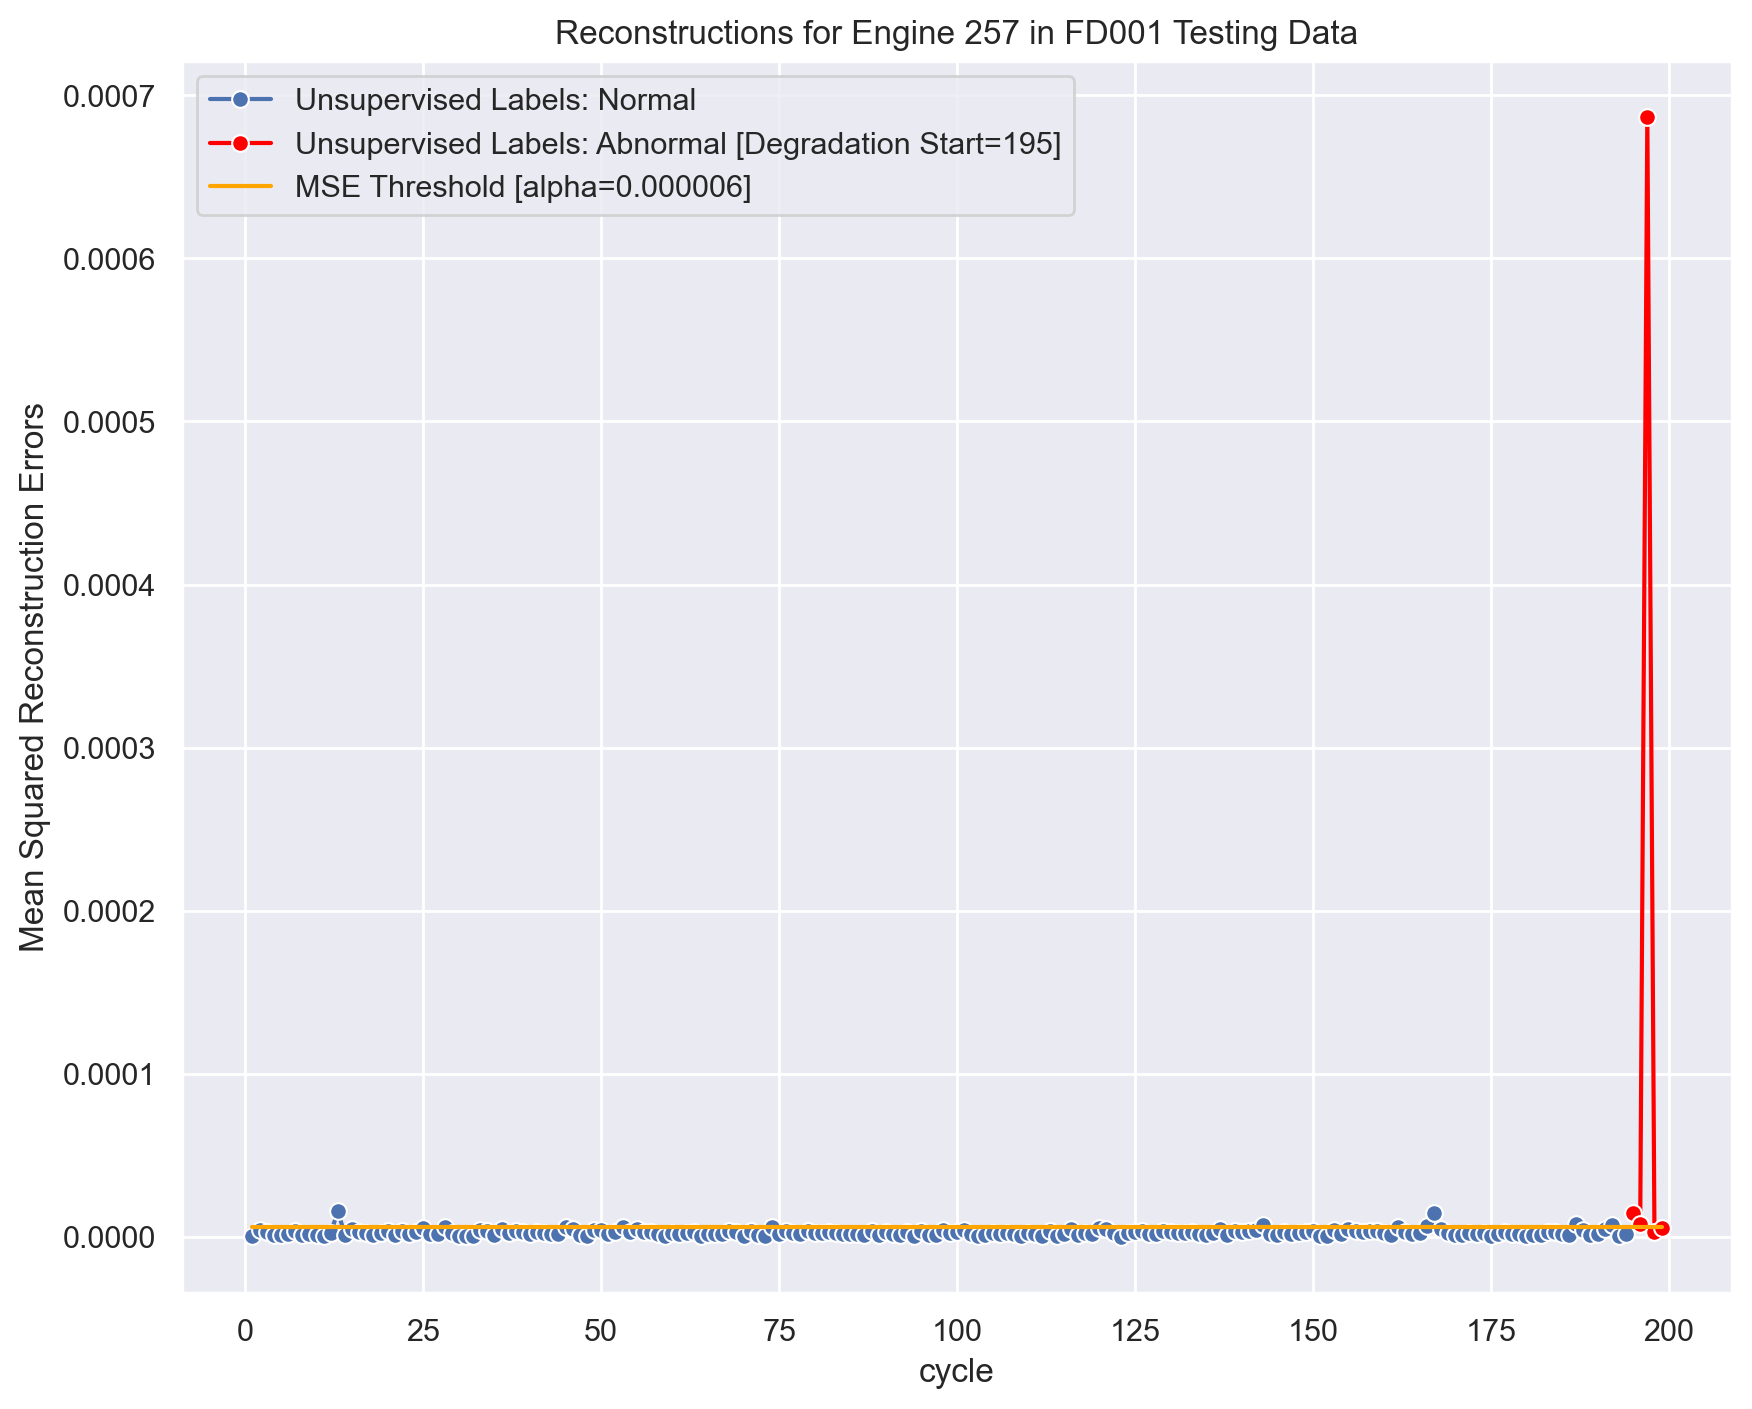

In [21]:
unit = 257
title = f"Reconstructions for Engine {unit} in FD001 Testing Data"
unit_threshold = unit_thresholds_dict[str(unit)]
df_unit = df_unsupervised_labels_testing.query(f"unit=={unit}")
number_normal_samples = math.ceil((normal_op_len / 100) * len(df_unit)) if norm_op_len_as_pct else normal_op_len

plot_labels_recon_errors_and_threshold(model, 
                                       number_normal_samples=0,
                                       df=df_unit, 
                                       threshold=unit_threshold,
                                       features=TURBOFAN_FEATURES_LIST,
                                       title=title,
                                       recon_errors_title="Mean Squared Reconstruction Errors", 
                                       threshold_title=f"MSE Threshold [alpha={unit_threshold:0.6f}]", 
                                       x_axis_column="cycle", 
                                       show_zoom_ins=False)

In [22]:
ruls = []
cycles = []
for unit in list(df_unsuperivsed_labels_training["unit"].unique()):
    df_unit = df_unsuperivsed_labels_training.query(f"unit=={unit} and fault==1")
    max_rul = df_unit["RUL"].max()
    cycle = df_unit["cycle"].min()
    
    ruls.append(max_rul)
    cycles.append(cycle)

print(f"Smallest Maximum RUL: {min(ruls)}")
print(f"Largets Maximum RUL: {max(ruls)}")
print(f"Average RUL: {np.mean(ruls)}")
print(f"Median RUL: {np.median(ruls)}\n")

print(f"Smallest Cycle: {min(cycles)}")
print(f"Largest Cycle: {max(cycles)}")
print(f"Average Cycle: {np.mean(cycles)}")
print(f"Median Cycle: {np.median(cycles)}")
# print(f"Largest_RUL + Median_RUL = {np.median(ruls) + max(ruls)}")

Smallest Maximum RUL: 4
Largets Maximum RUL: 109
Average RUL: 32.30384615384615
Median RUL: 26.0

Smallest Cycle: 106
Largest Cycle: 329
Average Cycle: 174.46153846153845
Median Cycle: 166.5


Smallest Cycle where a Fault Started: 106
Largest Cycle where a Fault Started: 329
Number of samples: 260


<Axes: ylabel='Count'>

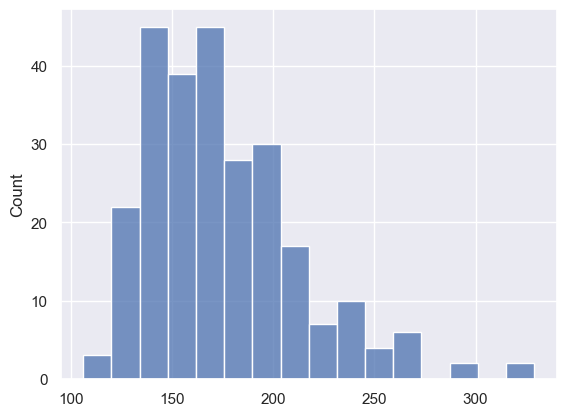

In [23]:
fault_start_training_data = []
for eng in df_unsuperivsed_labels_training["unit"].unique().tolist():
    df_unit = df_unsuperivsed_labels_training.query(f"unit=={eng} and fault==1")
    if len(df_unit) > 0:
        unit_fault_start = df_unit["cycle"].to_numpy()[0]
        fault_start_training_data.append(unit_fault_start)
    
print(f"Smallest Cycle where a Fault Started: {min(fault_start_training_data)}")
print(f"Largest Cycle where a Fault Started: {max(fault_start_training_data)}")
print(f"Number of samples: {len(fault_start_training_data)}")
sns.histplot(fault_start_training_data)

Smallest Cycle where a Fault Started: 87
Largest Cycle where a Fault Started: 278
Number of samples: 61


<Axes: ylabel='Count'>

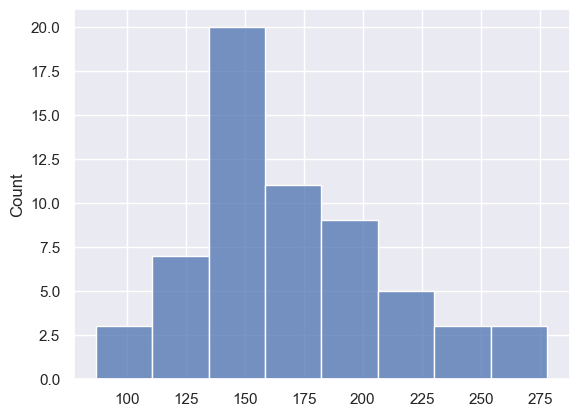

In [24]:
fault_start_testing_data = []
for eng in df_unsupervised_labels_testing["unit"].unique().tolist():
    df_unit = df_unsupervised_labels_testing.query(f"unit=={eng} and fault==1")
    if len(df_unit) > 0:
        unit_fault_start = df_unit["cycle"].to_numpy()[0]
        fault_start_testing_data.append(unit_fault_start)
        
        if unit_fault_start == 1:
            print(f"Unit={eng}")

print(f"Smallest Cycle where a Fault Started: {min(fault_start_testing_data)}")
print(f"Largest Cycle where a Fault Started: {max(fault_start_testing_data)}")
print(f"Number of samples: {len(fault_start_testing_data)}")
sns.histplot(fault_start_testing_data)

In [25]:
df_latent_space = get_latent_space_df(model=model, 
                                      df=df_unsuperivsed_labels_training, 
                                      unit_col_identifier_name="unit",
                                      cycle_col="cycle",
                                      features_list=TURBOFAN_FEATURES_LIST)

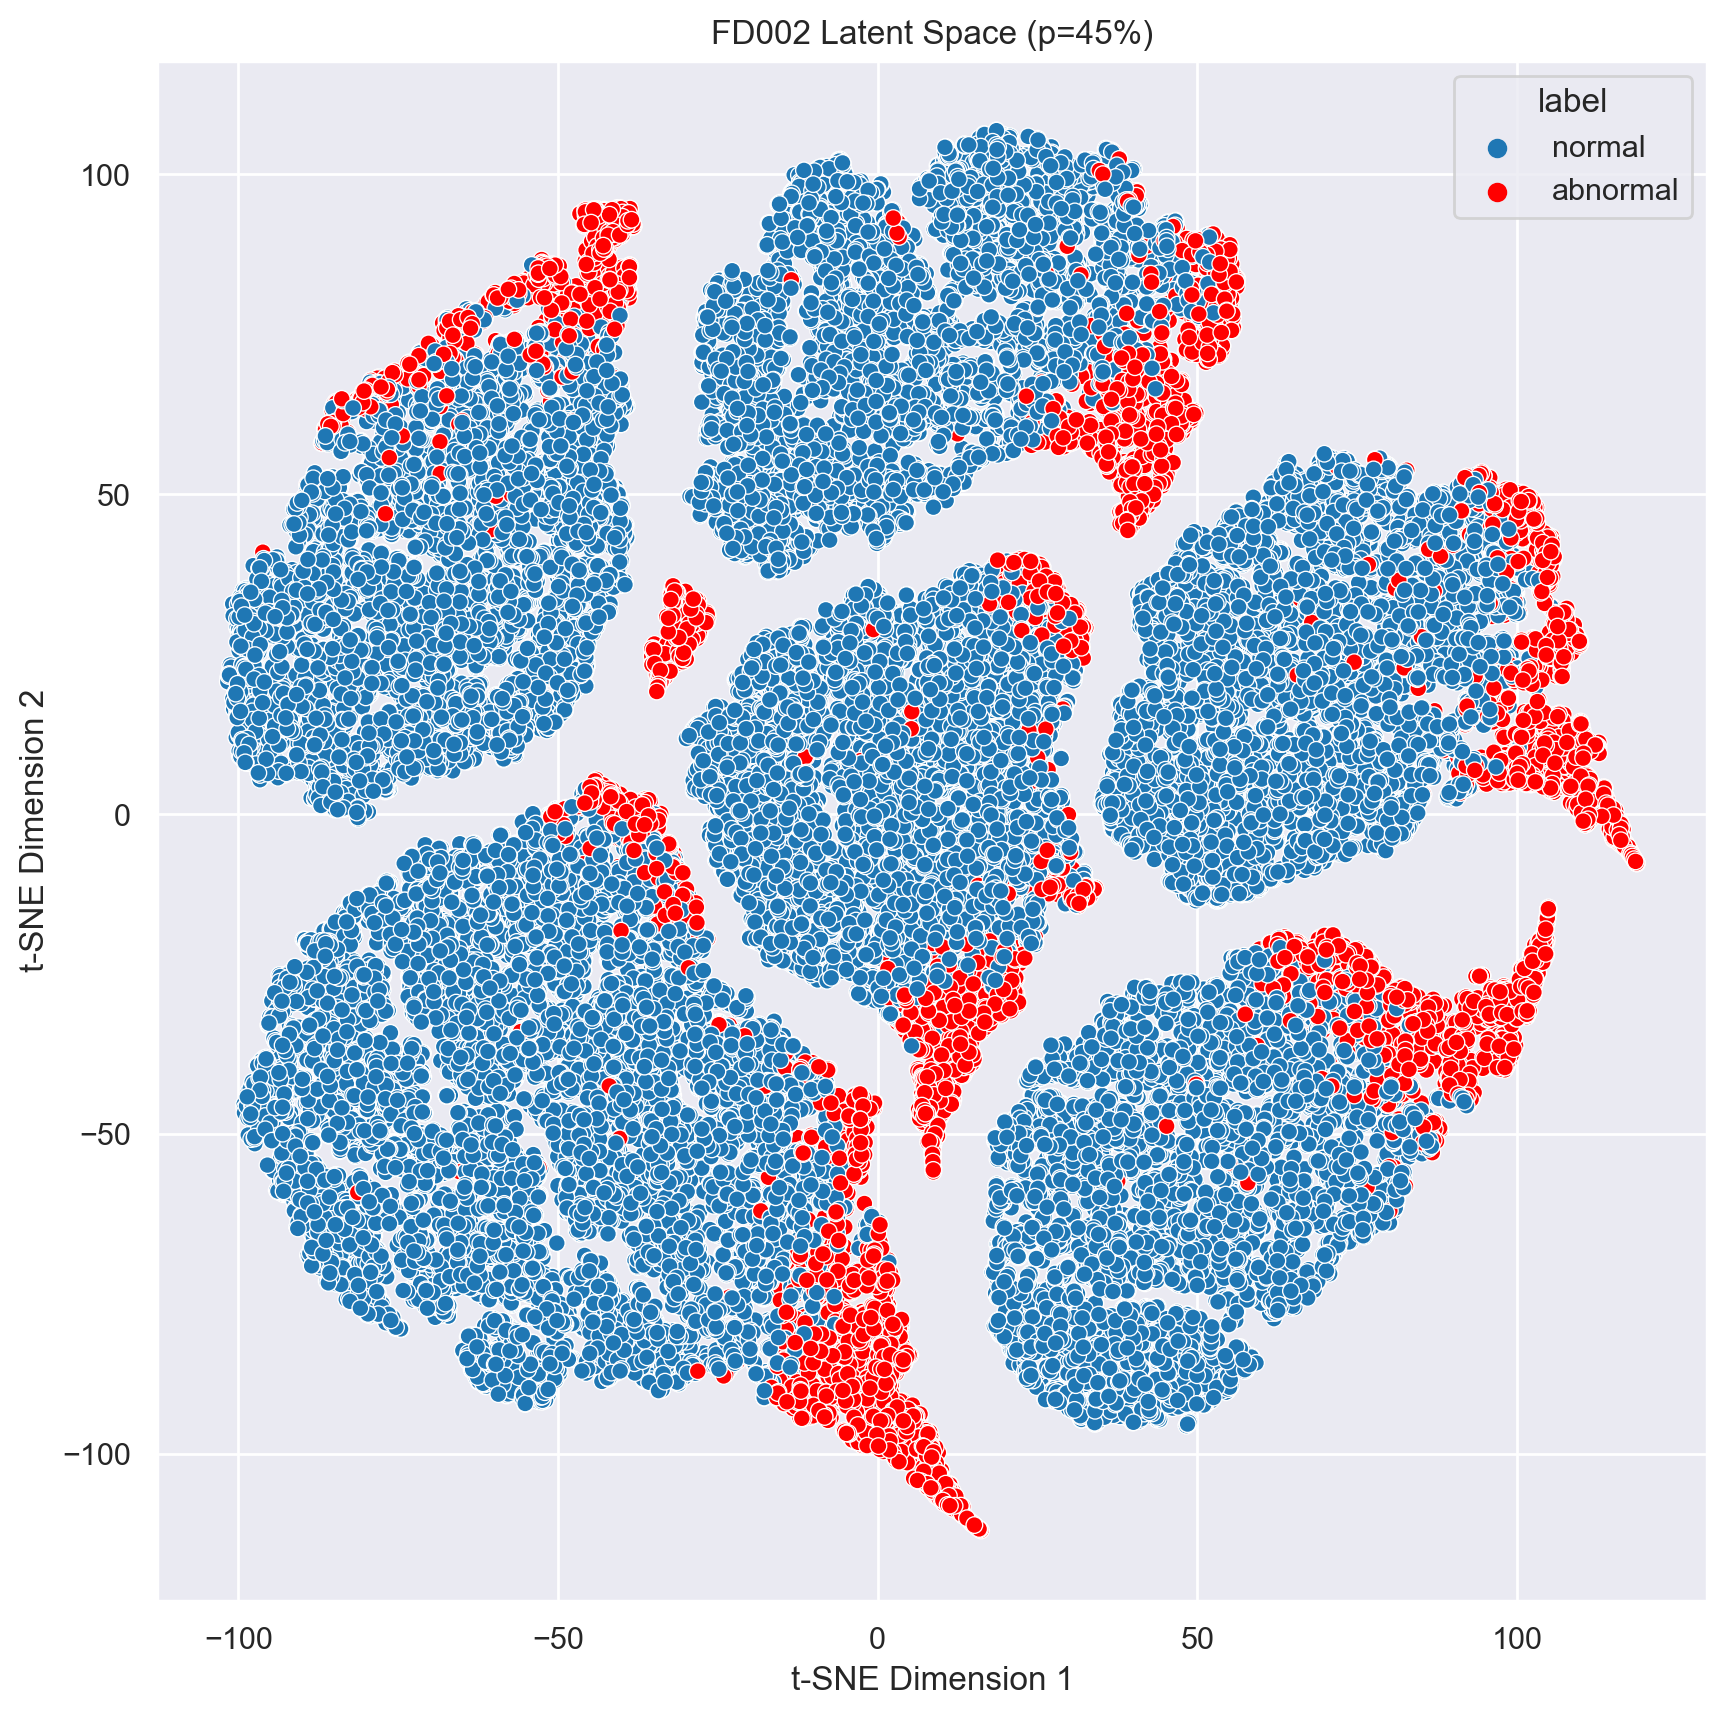

In [26]:
plot_latent_space(df_latent_space, 
                  title=f"{dataset} Latent Space (p={normal_op_len}%)", 
                  x_label="t-SNE Dimension 1", 
                  y_label="t-SNE Dimension 2")